# Traning

Traning Spaceship-Titanic model.

This notebook will use MLflow to track the model training process.

## Data

Note: the `train.csv` is the unique dataset that has the target column (**Transported**).

Because of that, we will split the data into train and test datasets. The test dataset will be used to evaluate the model after training.

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv('data/spaceshit-titanic/train.csv')

X, y = data.drop('Transported', axis=1), data['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)


## Pipeline building

In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline   import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

## 1. Columns separation
# Categorical columns
categorical_columns = [
    'Group', # it will be created by the passenger_id_spliter
    'Deck', # it will be created by the cabin_spliter
    'Num', # it will be created by the cabin_spliter
    'Side', # it will be created by the cabin_spliter
    'VIP',
    'CryoSleep',
    'HomePlanet',
    'Destination'
]
# Categorical columns to encode. They have low cardinality
columns_to_encode = [
    'Deck', # it will be created by the cabin_spliter
    'Side', # it will be created by the cabin_spliter
    'VIP',
    'CryoSleep',
    'HomePlanet',
    'Destination'
]

# Numeric columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Added new numeric columns
numeric_columns.extend([
    'Group', # it will be created by the passenger_id_spliter
    'Num' # it will be created by the cabin_spliter
])

## 2. FunctionTransformers. Custom transformers for columns
# Function
def passenger_id_spliter(passenger_id_col: pd.Series) -> pd.DataFrame:
    '''Function to split the passenger id into two columns

    Args:
        passenger_id_col: pd.Series - The passenger id column

    Returns:
        pd.DataFrame - The dataframe with the two columns (Group, Number)
    '''
    df = (
        pd.DataFrame(
            passenger_id_col
            .str
            .split('_')
            .to_list(),
        columns=['Group', 'Number'],
        index=passenger_id_col.index
        )
        .drop('Number', axis=1)
    )
    return df

def cabin_spliter(cabin_col: pd.Series) -> pd.DataFrame:
    '''Function to split the cabin into two columns

    Args:
        cabin_col: pd.Series - The cabin column

    Returns:
        pd.DataFrame - The dataframe with three columns (Deck, Num, Side)
    '''
    df = (
        cabin_col
        .str
        .split('/', expand=True)
        .rename(columns={0: 'Deck', 1: 'Num', 2: 'Side'})
    )

    return df

## 3. Transformer instantiation

# Custom transformers
passenger_id_transformer = FunctionTransformer(func=passenger_id_spliter,
    feature_names_out=lambda _, __: np.array(['Group'])
)

cabin_transformer = FunctionTransformer(func=cabin_spliter,
    feature_names_out=lambda _, __: np.array(['Deck', 'Num', 'Side'])
)

# Encoders
encoder = OrdinalEncoder()
one_hot = OneHotEncoder()

# Scalers
scaler = StandardScaler()

# Imputer
knn = KNNImputer(n_neighbors=10, weights='uniform')
simple_imputer = SimpleImputer(strategy='median')

# Rounder for the categorical columns
rounder = FunctionTransformer(func=lambda x: np.round(x, 0),
    feature_names_out=lambda _, __: columns_to_encode
)

## 4. Transformers pipeline

# Columns splitter function transformer
splitter_transformer = ColumnTransformer(
    transformers=[
        ('passenger_id', passenger_id_transformer, 'PassengerId'),
        ('cabin', cabin_transformer, 'Cabin')
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Enconder the categorical columns
encoder_transfomer = ColumnTransformer(
    transformers=[
        ('encoder', encoder, columns_to_encode)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Imputers and dropping high cardinality columns
imputer_transformer = ColumnTransformer(
    transformers=[
        ('numeric_imputer', simple_imputer, numeric_columns),
        ('categorical_imputer', knn, columns_to_encode)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Rounder and scalers
rounder_scaler_transformer = ColumnTransformer(
    transformers=[
        ('rounder', rounder, columns_to_encode),
        ('scaler', scaler, numeric_columns)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Dropping columns
drop_columns_transformer = ColumnTransformer(
    transformers=[
        ('drop', 'drop', 'Name')
    ],
    remainder='passthrough',
    force_int_remainder_cols=False, #type: ignore
    verbose_feature_names_out=False
)

# Gather all transformers into a pipeline
transfomers = Pipeline([
    ('splitter', splitter_transformer),
    ('encoder', encoder_transfomer),
    ('imputer', imputer_transformer),
    ('rounder_scaler', rounder_scaler_transformer),
    ('drop_columns', drop_columns_transformer)
])

# Garantee that the output of "transform" and "fit_transform" will be a pandas dataframe
# This is necessary due use label columns into transformers
transfomers.set_output(transform='pandas')

# Estimator to predict.
# Use a VotingClassifier to ensemble different models
nn = MLPClassifier(hidden_layer_sizes=(50, 5), activation='relu', max_iter=1000, random_state=42)
logistic = LogisticRegression(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

clfs = VotingClassifier(estimators=[
    ('nn', nn),
    ('logistic', logistic),
    ('random_forest', random_forest)
], voting='soft')

# Pipeline
clf = Pipeline([
    ('estimator', clfs)
])

# 5. Final pipeline
pipe = Pipeline([
    ('transformers', transfomers),
    ('clf', clf)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('transformers',
                 Pipeline(steps=[('splitter',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    remainder='passthrough',
                                                    transformers=[('passenger_id',
                                                                   FunctionTransformer(feature_names_out=<function <lambda> at 0x000001DEFD468540>,
                                                                                       func=<function passenger_id_spliter at 0x000001DEFD7A02C0>),
                                                                   'PassengerId'),
                                                                  ('cabin',
                                                                   FunctionTransformer(feature_n...
                                                    remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   'Name')],
                                                    verbose_feature_names_out=False))])),
                ('clf',
                 Pipeline(steps=[('estimator',
                                  VotingClassifier(estimators=[('nn',
                                                                MLPClassifier(hidden_layer_sizes=(50,
                                                                                                  5),
                                                                              max_iter=1000,
                                                                              random_state=42)),
                                                               ('logistic',
                                                                LogisticRegression(random_state=42)),
                                                               ('random_forest',
                                                                RandomForestClassifier(random_state=42))],
                                                   voting='soft'))]))])

## Evaluating

In [4]:
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
    precision_recall_curve, PrecisionRecallDisplay, f1_score, accuracy_score,
    recall_score, precision_score
)
from sklearn.model_selection import cross_val_score, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

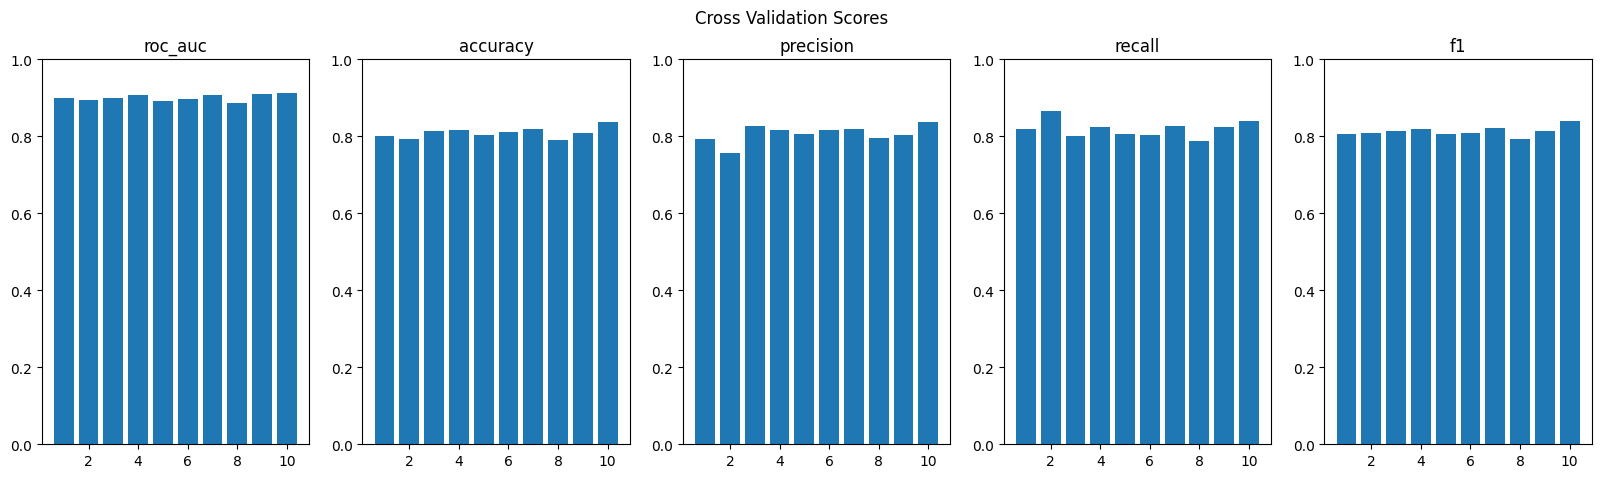

In [5]:
# Cross Validation
cv = cross_validate(pipe, X_train, y_train, cv=10, return_estimator=True, 
                    scoring=['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
                    )

# Plot the metric scores
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, metric in enumerate(['roc_auc', 'accuracy', 'precision', 'recall', 'f1']):
    ax[i].bar(range(1, 11), cv[f'test_{metric}'])
    ax[i].set_title(metric)
    ax[i].set_ylim(0, 1)
fig.suptitle('Cross Validation Scores')
plt.show()

In [6]:
# Get the best estimator based in the recall score
predictor = cv['estimator'][np.argmax(cv['test_f1'])]

# Predict the test set with the best estimator
y_pred = predictor.predict(X_test)

-------------------------------------------------- Reporting --------------------------------------------------
Cross Validation Results (mean, std):
ROC AUC:	 0.9004 , 0.008
Accuracy:	 0.8099 , 0.0129
Precision:	 0.8069 , 0.021
Recall:		 0.8194 , 0.021
F1:		 0.8127 , 0.0117

Best Estimator (based in the f1 score):
Estimator:
	VotingClassifier(estimators=[('nn',
                              MLPClassifier(hidden_layer_sizes=(50, 5),
                                            max_iter=1000, random_state=42)),
                             ('logistic', LogisticRegression(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42))],
                 voting='soft')

Evaluation in the test set
ROC AUC:	 0.891
Accuracy:	 0.8022
Precision:	 0.7846
Recall:		 0.8383
F1:		 0.8106



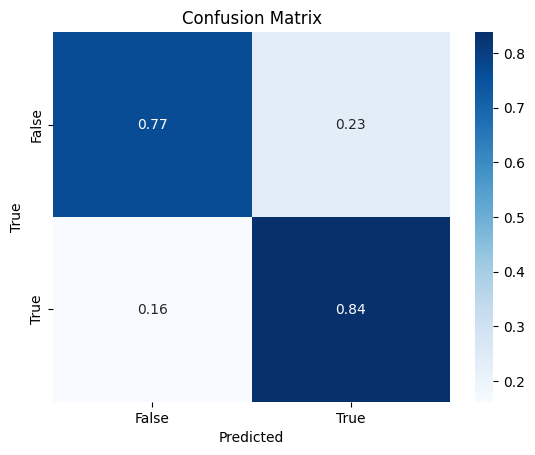

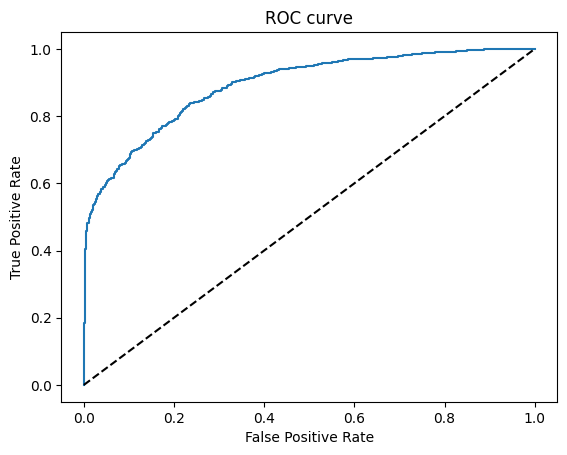

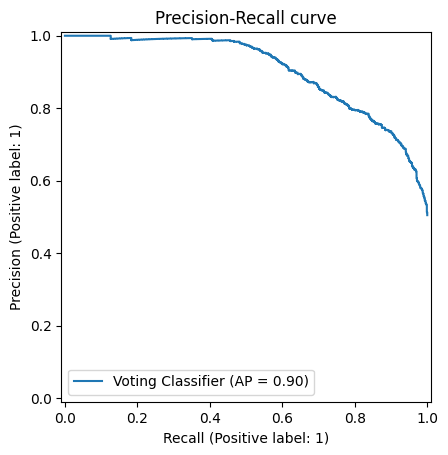

In [9]:
# Infos
print('-'*50, 'Reporting', '-'*50)

# Cross validation results
print('Cross Validation Results (mean, std):')
print(f'ROC AUC:\t {cv["test_roc_auc"].mean().round(4)} , {cv["test_roc_auc"].std().round(4)}')
print(f'Accuracy:\t {cv["test_accuracy"].mean().round(4)} , {cv["test_accuracy"].std().round(4)}')
print(f'Precision:\t {cv["test_precision"].mean().round(4)} , {cv["test_precision"].std().round(4)}')
print(f'Recall:\t\t {cv["test_recall"].mean().round(4)} , {cv["test_recall"].std().round(4)}')
print(f'F1:\t\t {cv["test_f1"].mean().round(4)} , {cv["test_f1"].std().round(4)}\n')



# Best estimator
print('Best Estimator (based in the f1 score):')
print(f'Estimator:\n\t{predictor.named_steps["clf"].named_steps["estimator"]}\n')

# Evaluation in the test set
print('Evaluation in the test set')
print(f'ROC AUC:\t {roc_auc_score(y_test, predictor.predict_proba(X_test)[:, 1]).round(4)}')
print(f'Accuracy:\t {round(accuracy_score(y_test, y_pred), 4)}')
print(f'Precision:\t {round(precision_score(y_test, y_pred), 4)}') #type: ignore
print(f'Recall:\t\t {round(recall_score(y_test, y_pred), 4)}') #type: ignore
print(f'F1:\t\t {round(f1_score(y_test, y_pred), 4)}\n') #type: ignore

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=predictor.classes_, 
            yticklabels=predictor.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictor.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Precision Recall Curve
disp = PrecisionRecallDisplay.from_estimator(predictor, X_test, y_test, name='Voting Classifier', pos_label=1)
_ = disp.ax_.set_title('Precision-Recall curve')

# Hyperparameters tuning

For hyperparameters tuning, the strategy will be to use a set of values either to transformer/estimators hyperparameters and the transformer/estimatores objects itself.

For instance, the transformer for imput values into numeric columns would be changed to `KNNImputer` or a `FunctionTransformer` with a custom function.

Theses ways of tuning will be done using `GridSearchCV` and `RandomizedSearchCV` from `sklearn.model_selection`.

## Pipeline building for hyperparameters tuning

In [8]:
from sklearn.model_selection import GridSearchCV

pipe.get_params()

{'memory': None,
 'steps': [('transformers', Pipeline(steps=[('splitter',
                    ColumnTransformer(force_int_remainder_cols=False,
                                      remainder='passthrough',
                                      transformers=[('passenger_id',
                                                     FunctionTransformer(feature_names_out=<function <lambda> at 0x000001DEFD468540>,
                                                                         func=<function passenger_id_spliter at 0x000001DEFD7A02C0>),
                                                     'PassengerId'),
                                                    ('cabin',
                                                     FunctionTransformer(feature_names_out=<function <lambda> at 0x00...
                                                     ['Deck', 'Side', 'VIP',
                                                      'CryoSleep', 'HomePlanet',
                                              

## Testing possibilities

1. Drop high cardinality new columns created after feature engineering: **Group** (from **PassengerId**) and **Num** (from **Cabin**).
   - Adding to dropping columns step
2. Impute 0 to missing values in numeric fields for passenger with CryoSleep equal to True.
   - Create a FunctionTransformer customize to impute.
3. Change the StardandScaler to MinMaxScaler and to a RobustScaler.
   - Add to the hyperparameters tuning.
4. Crate a range of hyperparameters to the classifiers.
   - Add to the hyperparameters tuning.
5. Create a range of hyperparameters to the imputers.
   - Add to the hyperparameters tuning.

In [14]:
numeric_columns

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group',
 'Num']

In [16]:
def cryo_spleep_imputer(numeric_columns: list):
    '''Function to impute the CryoSleep column based in the mean of the other columns   
    '''
    print(numeric_columns)
    return numeric_columns

passenger_id_transformer = FunctionTransformer(func=passenger_id_spliter)

# ColumnTransformer(
#     transformers=[
#         ('cryo_sleep_imputer', cryo_spleep_imputer, 'PassengerId')
#     ],
#     remainder='passthrough'
# ).fit_transform(X_train)

X_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
2333,2513_01,Earth,False,NaN,TRAPPIST-1e,28.0,False,0.0,55.0,0.0,656.0,0.0,Loree Mathison
2589,2774_02,Earth,False,F/575/P,TRAPPIST-1e,17.0,False,0.0,1195.0,31.0,0.0,0.0,Crisey Mcbriddley
8302,8862_04,Europa,True,C/329/S,55 Cancri e,28.0,False,0.0,0.0,0.0,0.0,0.0,Alramix Myling
8177,8736_02,Mars,False,F/1800/P,TRAPPIST-1e,20.0,False,NaN,2.0,289.0,976.0,0.0,Tros Pota
500,0539_02,Europa,True,C/18/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Achyon Nalanet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,6076_01,Earth,NaN,G/988/S,TRAPPIST-1e,18.0,False,14.0,2.0,144.0,610.0,0.0,Therry Cames
5191,5537_01,Mars,False,F/1063/S,TRAPPIST-1e,50.0,NaN,690.0,0.0,30.0,762.0,428.0,Herms Bancy
5390,5756_06,Earth,False,F/1194/P,PSO J318.5-22,22.0,False,158.0,0.0,476.0,0.0,26.0,Karena Briggston
860,0925_01,Mars,False,F/191/P,TRAPPIST-1e,34.0,False,379.0,0.0,1626.0,0.0,0.0,Skix Kraie


In [ ]:


# Setting the parameter grid
param_grid = {
    
}

from sklearn.model_selection import RandomizedSearchCV

# grid = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', n_jobs=-1)

grid = RandomizedSearchCV

In [16]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformers',
                                        Pipeline(steps=[('splitter',
                                                         ColumnTransformer(force_int_remainder_cols=False,
                                                                           remainder='passthrough',
                                                                           transformers=[('passenger_id',
                                                                                          FunctionTransformer(feature_names_out=<function <lambda> at 0x000002BB8D957740>,
                                                                                                              func=<function passenger_id_spliter at 0x000002BB8D9572E0>),
                                                                                          'PassengerId'),
                                                                                         ('cabin',
                                                                                          F...
                                                                           transformers=[('drop',
                                                                                          'drop',
                                                                                          'Name')],
                                                                           verbose_feature_names_out=False))])),
                                       ('clf',
                                        Pipeline(steps=[('estimator',
                                                         MLPClassifier(hidden_layer_sizes=(50,
                                                                                           5),
                                                                       max_iter=1000,
                                                                       random_state=42))]))]),
             n_jobs=-1,
             param_grid={'clf__estimator': [MLPClassifier(hidden_layer_sizes=(50,
                                                                              5),
                                                          max_iter=1000,
                                                          random_state=42),
                                            LogisticRegression(random_state=42)]},
             scoring='recall')